**Linear Gaussian SSM**

This is a LinearGaussianSSM where the latent dynamics are linear, but the emissions depend on the product of the latent variable (weights) times the input, which we achieve by taking **time-varying emission weights**.
$$
dynamics: \qquad w_t=Fw_{t-1}+b+\epsilon_t\ , P(w_t|w_{t-1})=N(w_t|Fw_{t-1}+b,Q)
$$

$$
emission: \qquad y_t=H_t w_t \ , P(y_t|z_t)=N(y_t|H_tw_t+d,R)
$$

where the time-dependent emissions weights $H_t=x_t$ represent input variables. We closely follow the notebook [Online linear regression using Kalman filtering](https://probml.github.io/dynamax/notebooks/linear_gaussian_ssm/kf_linreg.html).

In [1]:
import dynamax

from jax import numpy as jnp
from jax import random as jr
import jax
# from matplotlib import pyplot as plt

from ssm.util import random_rotation, find_permutation
from dynamax.utils.plotting import  plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import ParamsLGSSM, LinearGaussianSSM
from itertools import count

from jax.lib import xla_bridge

# print(jaxlib.version.version)
print(xla_bridge.get_backend().platform)
print(jax.devices())

from matplotlib import pyplot as plt


cpu
[CpuDevice(id=0)]


In [3]:
def plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    plt.plot(marginal_lls, label="estimated")
    if len(true_model)>0:
        true_logjoint = (true_model.log_prior(true_params) + true_model.marginal_log_prob(true_params, emissions))
        plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.ylabel("marginal joint probability")
    plt.legend()

def print_params_lgssm(params):
    jnp.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    print("initial mean:")
    print(params.initial.mean)        
    print("initial cov:")
    print(params.initial.cov)
    print("dynamics weights F:")
    print(params.dynamics.weights)
    print("dynamics bias b:")
    print(params.dynamics.bias)
    print("dynamics cov Q:")
    print(params.dynamics.cov)
    print("emission cov R:")
    print(params.emissions.cov) # since num_emissions = 1
    print("emission weights H dimension: [num_timesteps,1,emission_dim]")
    print(params.emissions.weights.shape) # since num_emissions = 1    
    if len(params.emissions.weights.shape)==3:
        print("emission weights H_t: first 3 steps")
        print(params.emissions.weights[:3, 0, :]) # since num_emissions = 1
    else:
        print("emission weights H:")
        print(params.emissions.weights) # since num_emissions = 1
        

**First issue: sampling**

We first set by hand the model parameters, and then sample data from the model with time-varying emission weights H_t. It should generate emissions with dimension (num_timesteps,emission_dim) but instead it generates emissions with dimension (num_timesteps,num_timesteps,emission_dim).

In [4]:
n_obs = 100
x = jnp.linspace(0, 5, n_obs) # input values
X = jnp.column_stack((x,jnp.ones_like(x)))  # Design matrix = time-dependent emission weights
# y = jnp.array(
    # [2.486, -0.303, -4.053, -4.336, -6.174, -5.604, -3.507, -2.326, -4.638, -0.233, -1.986, 1.028, -2.264,
    #  -0.451, 1.167, 6.652, 4.145, 5.268, 6.34, 9.626, 14.784]) 

# simplest model from dynamax_kf_linreg
F = jnp.eye(2) # dynamics
Q = jnp.ones((2, 2))  # dynamics cov
obs_var = 1.0
R = jnp.ones((1, 1)) * obs_var  # emission cov
mu0 = jnp.zeros(2) # initial distribution
Sigma0 = jnp.eye(2) * 10.0 # initial distribution

keys = map(jr.PRNGKey, count())


# the input_dim = 0 since we encode the covariates into the non-stationary emission matrix
lgssm = LinearGaussianSSM(state_dim = 2, emission_dim = 1, input_dim = 0)
em_params, em_param_props = lgssm.initialize(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_weights=F,
    dynamics_covariance=Q,
    emission_weights=X[:, None, :], # (t, 1, D) where D = num input features
    emission_covariance=R,
    )
print_params_lgssm(em_params)

data_latent,data_obs=lgssm.sample(em_params,next(keys),num_timesteps=n_obs)

print('latents shape:')
print(data_latent.shape)
print('emissions shape:')
print(data_obs.shape)

# # Plot Data
# emissions=data_obs
# latents=data_latent
# (nsteps,emi1,emi2)=emissions.shape
# state_dim=len(latents[0])
# # Plot the true states and emissions
# fig, ax = plt.subplots(2,1,figsize=(10, 8))
# for i in range(state_dim):
#     ax[0].plot(latents[:][i] + i * jnp.arange(state_dim))
# # ax[1].plot(emissions + 3 * jnp.arange(emi1))
# ax[0].set_ylabel("latents")
# ax[0].set_xlabel("time")
# ax[0].set_xlim(0, nsteps - 1)



initial mean:
[0.000 0.000]
initial cov:
[[10.000 0.000]
 [0.000 10.000]]
dynamics weights F:
[[1.000 0.000]
 [0.000 1.000]]
dynamics bias b:
[0.000 0.000]
dynamics cov Q:
[[1.000 1.000]
 [1.000 1.000]]
emission cov R:
[[1.000]]
emission weights H dimension: [num_timesteps,1,emission_dim]
(100, 1, 2)
emission weights H_t: first 3 steps
[[0.000 1.000]
 [0.051 1.000]
 [0.101 1.000]]
latents shape:
(100, 2)
emissions shape:
(100, 100, 1)


**Second issue: inference**

We now use given inputs and emissions data, and use lgssm to perform em inference to find the model parameter that generate the data. We use time-varying emission weights H_t initialized to their values and then frozen during inference (Trainable==False). When performing inference using fit_em, somehow the time-varying emissions weights change even though they should be frozen and loose their time dependence!

initial mean:
[0.000 0.000]
initial cov:
[[1.000 0.000]
 [0.000 1.000]]
dynamics weights F:
[[0.990 0.000]
 [0.000 0.990]]
dynamics bias b:
0
dynamics cov Q:
[[0.100 0.000]
 [0.000 0.100]]
emission cov R:
[[0.100]]
emission weights H dimension: [num_timesteps,1,emission_dim]
(21, 1, 2)
emission weights H_t: first 3 steps
[[0.000 1.000]
 [1.000 1.000]
 [2.000 1.000]]


initial mean:
[-1.681 2.622]
initial cov:
[[0.000 0.000]
 [0.000 0.000]]
dynamics weights F:
[[1.097 -0.184]
 [-0.096 0.525]]
dynamics bias b:
[0.324 -0.284]
dynamics cov Q:
[[0.000 0.000]
 [0.000 0.002]]
emission cov R:
[[2.298]]
emission weights H dimension: [num_timesteps,1,emission_dim]
(1, 2)
emission weights H:
[[3.067 2.502]]


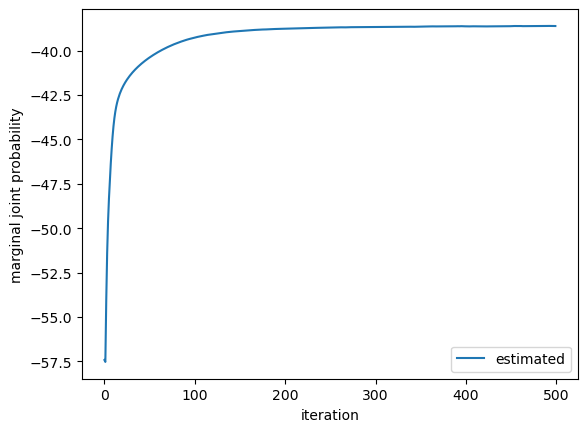

In [5]:
n_obs = 21
x = jnp.linspace(0, 20, n_obs) # time dependent weights x_t
X = jnp.column_stack((x,jnp.ones_like(x)))  # Design matrix.
y = jnp.array(
    [2.486, -0.303, -4.053, -4.336, -6.174, -5.604, -3.507, -2.326, -4.638, -0.233, -1.986, 1.028, -2.264,
     -0.451, 1.167, 6.652, 4.145, 5.268, 6.34, 9.626, 14.784]) # emissions
keys = map(jr.PRNGKey, count())

# learn the model parameter that generate the observed dynamics
# the input_dim = 0 since we encode the covariates into the non-stationary emission matrix
lgssm = LinearGaussianSSM(state_dim = 2, emission_dim = 1, input_dim = 0)
params, params_prop = lgssm.initialize(next(keys),
    # initial_mean=mu0,
    # initial_covariance=Sigma0,
    dynamics_bias=0,
#     dynamics_weights=F,
#     dynamics_covariance=Q,
    emission_weights=X[:, None, :], # (t, 1, D) where D = num input features
    emission_bias=0,
#     emission_covariance=R,
    )

# Set transition parameters and inital parameters to true values and mark as frozen
# params_prop.dynamics.weights.trainable = False
params_prop.dynamics.bias.trainable = False
params_prop.emissions.weights.trainable = False
params_prop.emissions.bias.trainable = False
num_iters = 500
print_params_lgssm(params)

test_params,marginal_lls=lgssm.fit_em(params,params_prop, emissions=y[:, None], num_iters=num_iters)
# lgssm.fit_em(params,params_prop, emissions=y[:, None], num_iters=num_iters)
plot_learning_curve(marginal_lls, [], [], lgssm, test_params, y)

data_latent,data_obs=lgssm.sample(test_params,next(keys), num_timesteps=100)
print_params_lgssm(test_params)

**Third issue: inference with SGD**

We use given inputs and emissions data, and use lgssm to perform **SGD** inference to find the model parameter that generate the data. SGD gives some error message.

In [9]:
n_obs = 21
x = jnp.linspace(0, 20, n_obs) # time dependent weights x_t
X = jnp.column_stack((x,jnp.ones_like(x)))  # Design matrix.
y = jnp.array(
    [2.486, -0.303, -4.053, -4.336, -6.174, -5.604, -3.507, -2.326, -4.638, -0.233, -1.986, 1.028, -2.264,
     -0.451, 1.167, 6.652, 4.145, 5.268, 6.34, 9.626, 14.784]) # emissions
keys = map(jr.PRNGKey, count())

# learn the model parameter that generate the observed dynamics
# the input_dim = 0 since we encode the covariates into the non-stationary emission matrix
lgssm = LinearGaussianSSM(state_dim = 2, emission_dim = 1, input_dim = 0)
params, params_prop = lgssm.initialize(next(keys),
    # initial_mean=mu0,
    # initial_covariance=Sigma0,
    dynamics_bias=0,
#     dynamics_weights=F,
#     dynamics_covariance=Q,
    emission_weights=X[:, None, :], # (t, 1, D) where D = num input features
    emission_bias=0,
#     emission_covariance=R,
    )

# Set transition parameters and inital parameters to true values and mark as frozen
# params_prop.dynamics.weights.trainable = False
params_prop.dynamics.bias.trainable = False
params_prop.emissions.weights.trainable = False
params_prop.emissions.bias.trainable = False
num_iters = 500
print_params_lgssm(params)

test_params,marginal_lls=lgssm.fit_sgd(params,params_prop, emissions=y[:, None], num_epochs=num_iters)
# lgssm.fit_em(params,params_prop, emissions=y[:, None], num_iters=num_iters)
plot_learning_curve(marginal_lls, [], [], lgssm, test_params, y)

data_latent,data_obs=lgssm.sample(test_params,next(keys), num_timesteps=100)
print_params_lgssm(test_params)

initial mean:
[0.000 0.000]
initial cov:
[[1.000 0.000]
 [0.000 1.000]]
dynamics weights F:
[[0.990 0.000]
 [0.000 0.990]]
dynamics bias b:
0
dynamics cov Q:
[[0.100 0.000]
 [0.000 0.100]]
emission cov R:
[[0.100]]
emission weights H dimension: [num_timesteps,1,emission_dim]
(21, 1, 2)
emission weights H_t: first 3 steps
[[0.000 1.000]
 [1.000 1.000]
 [2.000 1.000]]


TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.